## Data Cleaning & Preparation

In [34]:
import numpy as np
import pandas as pd
import os
import re
from bs4 import BeautifulSoup
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from gensim.models import Word2Vec, Doc2Vec
from gensim.models.doc2vec import TaggedDocument

# Download NLTK resources
nltk.download('stopwords')
nltk.download('wordnet')

# Constants
VOCAB_SIZE = 10000
EMBEDDING_DIM = 100
MAX_SEQUENCE_LENGTH = 200
BATCH_SIZE = 32
EPOCHS = 10

# Initialize lemmatizer and stopwords
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

# Helper functions
def extract_numeric_rating(rating):
    if isinstance(rating, str):
        match = re.search(r'(\d+(\.\d+)?)', rating)
        if match:
            return float(match.group(1))
    return rating

def is_english(text):
    try:
        return detect(text) == 'en'
    except:
        return False

def preprocess_text(text):
    text = text.lower()  # Convert to lowercase
    text = re.sub(r'[^\w\s]', '', text)  # Remove punctuation
    text = ' '.join([lemmatizer.lemmatize(word) for word in text.split() if word not in stop_words])  # Remove stopwords and lemmatize
    return text

def process_reviews(hotel_name, source_folders, output_folder):
    all_reviews = []

    for source_folder in source_folders:
        # Get all CSV files in the source folder
        files = [file for file in os.listdir(source_folder) if file.endswith('.csv')]
        print(f"Found {len(files)} files in {source_folder} for {hotel_name}")
        
        for file in files:
            if hotel_name in file:
                # Load the dataset
                file_path = os.path.join(source_folder, file)
                reviews = pd.read_csv(file_path)
                print(f"Processing file: {file_path} with {reviews.shape[0]} rows")
                
                # Check if the required columns are present
                if not all(col in reviews.columns for col in ['Review Content', 'Review Score', 'Review Time']):
                    print(f"Skipping file {file} due to missing required columns.")
                    continue
                
                # Remove irrelevant columns
                columns_to_keep = ['Review Content', 'Review Score', 'Review Time']
                reviews = reviews[columns_to_keep]
                
                # Remove missing values
                reviews.dropna(subset=['Review Content', 'Review Score'], inplace=True)
                print(f"After dropping missing values: {reviews.shape[0]} rows")
                
                # Extract numeric rating from textual ratings if necessary
                reviews['Review Score'] = reviews['Review Score'].apply(extract_numeric_rating)
                print(f"After extracting numeric ratings: {reviews.shape[0]} rows")
                
                # Normalize ratings to a common scale (0 to 1)
                scaler = MinMaxScaler(feature_range=(0, 1))
                reviews['Review Score'] = scaler.fit_transform(reviews[['Review Score']])
                print(f"After normalizing ratings: {reviews.shape[0]} rows")
                
                # Language detection and filtering for English reviews
                reviews = reviews[reviews['Review Content'].apply(is_english)]
                print(f"After filtering non-English reviews: {reviews.shape[0]} rows")
                
                # Remove HTML tags if necessary
                reviews['Review Content'] = reviews['Review Content'].apply(lambda x: BeautifulSoup(x, 'html.parser').get_text())
                print(f"After removing HTML tags: {reviews.shape[0]} rows")
                
                # Remove duplicates
                reviews.drop_duplicates(subset=['Review Content'], inplace=True)
                print(f"After removing duplicates: {reviews.shape[0]} rows")
                
                # Text preprocessing: convert to lowercase, remove punctuation, remove stopwords, and lemmatize
                reviews['Review Content'] = reviews['Review Content'].apply(preprocess_text)
                print(f"After text preprocessing: {reviews.shape[0]} rows")
                
                # Append to the list of all reviews
                all_reviews.append(reviews)

    # Combine all reviews into a single DataFrame
    if all_reviews:
        combined_reviews = pd.concat(all_reviews, ignore_index=True)
    else:
        combined_reviews = pd.DataFrame(columns=['Review Content', 'Review Score', 'Review Time'])
    
    print(f"Total combined reviews: {combined_reviews.shape[0]} rows")

    if combined_reviews.empty:
        print(f"No reviews available after preprocessing for hotel {hotel_name}.")
        return

    # Tokenize and pad sequences
    tokenizer = Tokenizer(num_words=VOCAB_SIZE)
    tokenizer.fit_on_texts(combined_reviews['Review Content'])
    sequences = tokenizer.texts_to_sequences(combined_reviews['Review Content'])
    padded_sequences = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH)

    # Prepare labels
    labels = combined_reviews['Review Score'].values

    # Split data into training and testing sets (70/30)
    x_train, x_test, y_train, y_test = train_test_split(padded_sequences, labels, test_size=0.3, random_state=42)

    # Save the preprocessed and vectorized dataset along with indices
    os.makedirs(output_folder, exist_ok=True)
    output_path = os.path.join(output_folder, f"{hotel_name}_preprocessed_reviews.npz")
    np.savez_compressed(output_path, x_train=x_train, x_test=x_test, y_train=y_train, y_test=y_test, x_test_indices=np.arange(len(x_test)))

    # Variable Identification
    x = combined_reviews['Review Content']
    y_ground_truth = combined_reviews['Review Score']

    # Vectorization using Word2Vec
    sentences = [review.split() for review in x]
    word2vec_model = Word2Vec(sentences, vector_size=EMBEDDING_DIM, window=5, min_count=1, workers=4)

    # Generate word vectors with consistent lengths
    x_vectorized = np.array([np.mean([word2vec_model.wv[word] for word in review.split() if word in word2vec_model.wv] or [np.zeros(EMBEDDING_DIM)], axis=0) for review in x])
    
    # Vectorization using Doc2Vec
    tagged_data = [TaggedDocument(words=review.split(), tags=[str(i)]) for i, review in enumerate(x)]
    doc2vec_model = Doc2Vec(tagged_data, vector_size=EMBEDDING_DIM, window=5, min_count=1, workers=4)
    x_doc2vec = np.array([doc2vec_model.infer_vector(review.split()) for review in x])

    # Normalize sentiment labels (y)
    y_normalized = (y_ground_truth - y_ground_truth.min()) / (y_ground_truth.max() - y_ground_truth.min())
    
    # Sentiment Label Preprocessing
    positive_threshold = 0.75
    negative_threshold = 0.25

    y_labels = np.zeros_like(y_normalized)
    y_labels[y_normalized >= positive_threshold] = 1
    y_labels[y_normalized <= negative_threshold] = -1
    y_labels[(y_normalized > negative_threshold) & (y_normalized < positive_threshold)] = 0

    # Add sentiment labels to the DataFrame for clarity
    combined_reviews['Sentiment Label'] = y_labels

    # Save preprocessed variables
    np.savez_compressed(output_path, x_train=x_train, x_test=x_test, y_train=y_train, y_test=y_test, 
                        x_vectorized=x_vectorized, x_doc2vec=x_doc2vec, y_labels=y_labels, x_test_indices=np.arange(len(x_test)))

    # Verify shapes
    print(f"x_train shape: {x_train.shape}")
    print(f"x_test shape: {x_test.shape}")
    print(f"y_train shape: {y_train.shape}")
    print(f"y_test shape: {y_test.shape}")
    print(f"x_vectorized shape: {x_vectorized.shape}")
    print(f"x_doc2vec shape: {x_doc2vec.shape}")
    print(f"y_labels shape: {y_labels.shape}")
    
# Define source and output folders using relative paths
def main():
    base_input_path = os.path.join('..', 'raw data')
    base_output_path = os.path.join('..', 'datasets')

    sources = ['agoda_hotel_reviews', 'booking_hotel_reviews', 'klook_hotel_reviews', 'tripadvisor_hotel_reviews']
    hotels = [
        'bai_hotel_reviews_2022_2024',
        'dusit_thani_mactan_reviews_2022_2024',
        'fairfield_by_marriott_cebu_reviews_2022_2024',
        'jpark_island_resort_and_waterpark_reviews_2022_2024',
        'seda_ayala_center_cebu_reviews_2022_2024',
        'waterfront_hotel_and_casino_reviews_2022_2024'
    ]

    # Mapping hotel names to numbered output folder names
    output_folder_names = {
        'bai_hotel_reviews_2022_2024': '1_bai_hotel',
        'dusit_thani_mactan_reviews_2022_2024': '2_dusit_thani_mactan',
        'fairfield_by_marriott_cebu_reviews_2022_2024': '3_fairfield_by_marriott_cebu',
        'jpark_island_resort_and_waterpark_reviews_2022_2024': '4_jpark_island_resort_and_waterpark',
        'seda_ayala_center_cebu_reviews_2022_2024': '5_seda_ayala_center_cebu',
        'waterfront_hotel_and_casino_reviews_2022_2024': '6_waterfront_hotel_and_casino'
    }

    source_folders = [os.path.join(base_input_path, source) for source in sources]

    for hotel in hotels:
        hotel_name = hotel.replace('_reviews_2022_2024', '')
        output_folder = os.path.join(base_output_path, output_folder_names[hotel])
        print(f"Processing {hotel_name} reviews...")
        process_reviews(hotel_name, source_folders, output_folder)
        print(f"Finished processing {hotel_name} reviews.")

if __name__ == "__main__":
    main()


Processing bai_hotel reviews...
Found 6 files in ..\raw data\agoda_hotel_reviews for bai_hotel
Processing file: ..\raw data\agoda_hotel_reviews\bai_hotel_reviews_2022_2024.csv with 1909 rows
After dropping missing values: 1909 rows
After extracting numeric ratings: 1909 rows
After normalizing ratings: 1909 rows
After filtering non-English reviews: 0 rows
After removing HTML tags: 0 rows
After removing duplicates: 0 rows
After text preprocessing: 0 rows
Found 6 files in ..\raw data\booking_hotel_reviews for bai_hotel
Processing file: ..\raw data\booking_hotel_reviews\bai_hotel_reviews_2022_2024.csv with 682 rows
After dropping missing values: 682 rows
After extracting numeric ratings: 682 rows
After normalizing ratings: 682 rows
After filtering non-English reviews: 0 rows
After removing HTML tags: 0 rows
After removing duplicates: 0 rows
After text preprocessing: 0 rows
Found 6 files in ..\raw data\klook_hotel_reviews for bai_hotel
Processing file: ..\raw data\klook_hotel_reviews\bai_ho

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\andyb\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\andyb\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


## EDA

In [35]:
import os
import numpy as np
import matplotlib.pyplot as plt

# Define the base path for datasets
base_output_path = os.path.join('..', 'datasets')

# List of hotel folders and their corresponding names for the EDA plots
hotel_folders = {
    '1_bai_hotel': 'bai_hotel',
    '2_dusit_thani_mactan': 'dusit_thani_mactan',
    '3_fairfield_by_marriott_cebu': 'fairfield_by_marriott_cebu',
    '4_jpark_island_resort_and_waterpark': 'jpark_island_resort_and_waterpark',
    '5_seda_ayala_center_cebu': 'seda_ayala_center_cebu',
    '6_waterfront_hotel_and_casino': 'waterfront_hotel_and_casino'
}

for folder, hotel_name in hotel_folders.items():
    output_folder = os.path.join(base_output_path, folder)
    
    # Load the preprocessed data
    data_path = os.path.join(output_folder, f"{hotel_name}_preprocessed_reviews.npz")
    data = np.load(data_path)
    
    x_train = data['x_train']
    x_test = data['x_test']
    y_train = data['y_train']
    y_test = data['y_test']
    
    # # For EDA purposes only
    # # Review lengths
    # review_lengths = [len(review) for review in x_train]
    # plt.hist(review_lengths, bins=50)
    # plt.title(f'{hotel_name} Review Lengths')
    # plt.xlabel('Review Length (in words)')
    # plt.ylabel('Frequency')
    # plt.show()
    
    # # Distribution of Ratings in Training Data
    # plt.hist(y_train, bins=10, edgecolor='k')
    # plt.title(f"{hotel_name} - Distribution of Ratings in Training Data")
    # plt.xlabel("Rating")
    # plt.ylabel("Frequency")
    # plt.show()
    
    # # Distribution of Sentiment Scores
    # plt.hist(y_train, bins=20, alpha=0.5, label='Training Data')
    # plt.hist(y_test, bins=20, alpha=0.5, label='Test Data')
    # plt.legend(loc='upper right')
    # plt.title(f'{hotel_name} - Distribution of Sentiment Scores')
    # plt.xlabel('Sentiment Score')
    # plt.ylabel('Frequency')
    # plt.show()

# General Sentiment Analysis




Training the CNN-biLSTM model for Hotel bai_hotel...
Epoch 1/10


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\andyb\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\andyb\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
c:\Users\andyb\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


76/76 ━━━━━━━━━━━━━━━━━━━━ 5s 41ms/step - accuracy: 0.6216 - loss: 0.2644 - val_accuracy: 0.6519 - val_loss: 0.2761
Epoch 2/10
76/76 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step - accuracy: 0.6523 - loss: 0.1804 - val_accuracy: 0.6519 - val_loss: 0.2739
Epoch 3/10
76/76 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - accuracy: 0.6465 - loss: 0.1634 - val_accuracy: 0.6519 - val_loss: 0.2739
Epoch 4/10
76/76 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step - accuracy: 0.6671 - loss: 0.1491 - val_accuracy: 0.6519 - val_loss: 0.2809
Epoch 5/10
76/76 ━━━━━━━━━━━━━━━━━━━━ 3s 39ms/step - accuracy: 0.6527 - loss: 0.1483 - val_accuracy: 0.6556 - val_loss: 0.2909
Epoch 6/10
76/76 ━━━━━━━━━━━━━━━━━━━━ 3s 37ms/step - accuracy: 0.6653 - loss: 0.1350 - val_accuracy: 0.6556 - val_loss: 0.3123
Epoch 7/10
76/76 ━━━━━━━━━━━━━━━━━━━━ 3s 40ms/step - accuracy: 0.6639 - loss: 0.1315 - val_accuracy: 0.6519 - val_loss: 0.2845
Epoch 8/10
76/76 ━━━━━━━━━━━━━━━━━━━━ 3s 36ms/step - accuracy: 0.6430 - loss: 0.1377 - val_accuracy: 0.6519 - val_loss: 0.

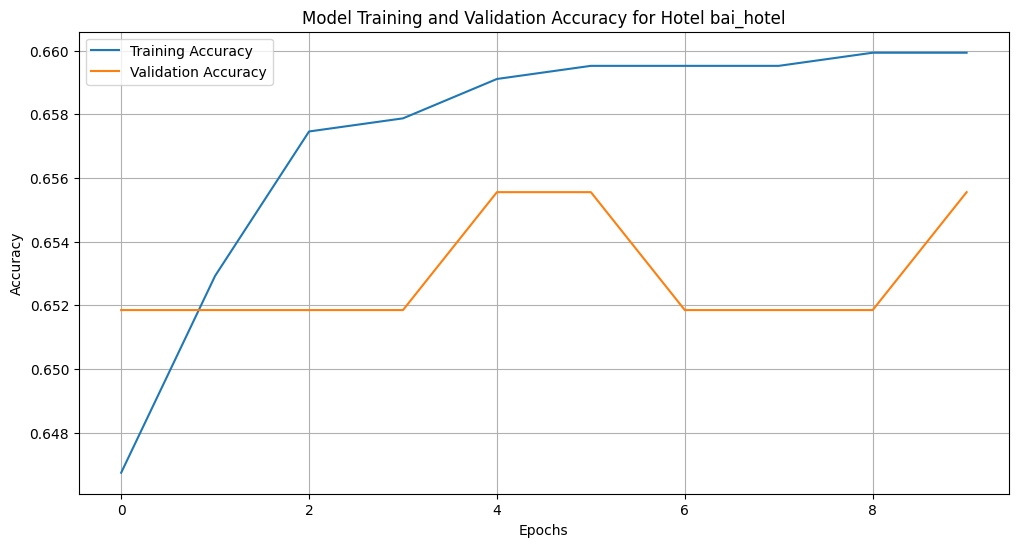

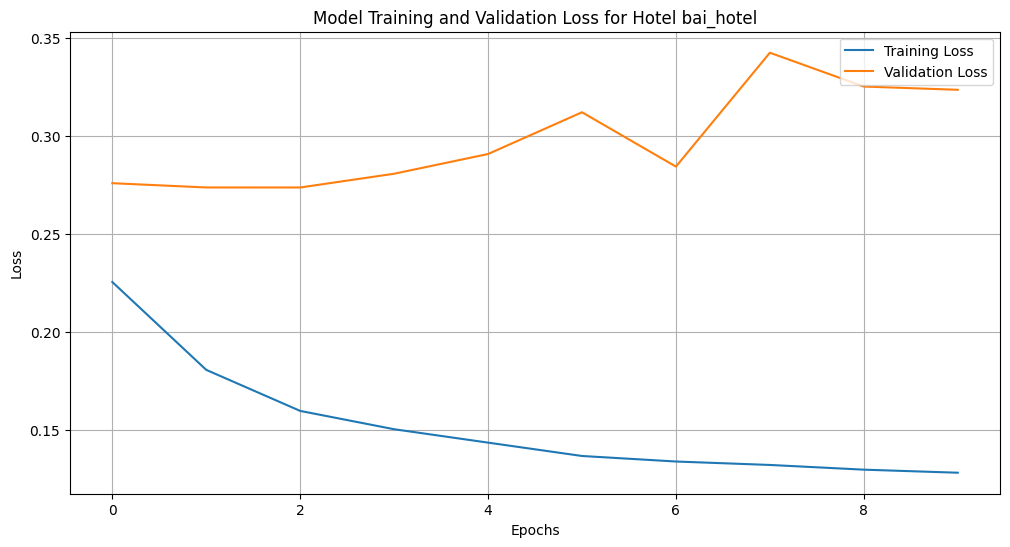

37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.6408 - loss: 0.3379
Test Loss for Hotel bai_hotel: 0.3119027018547058
Test Accuracy for Hotel bai_hotel: 0.6505190134048462
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step

Classification Report for Hotel bai_hotel:
              precision    recall  f1-score   support

    Negative       0.57      0.08      0.14        52
    Positive       0.96      1.00      0.98      1104

    accuracy                           0.96      1156
   macro avg       0.76      0.54      0.56      1156
weighted avg       0.94      0.96      0.94      1156



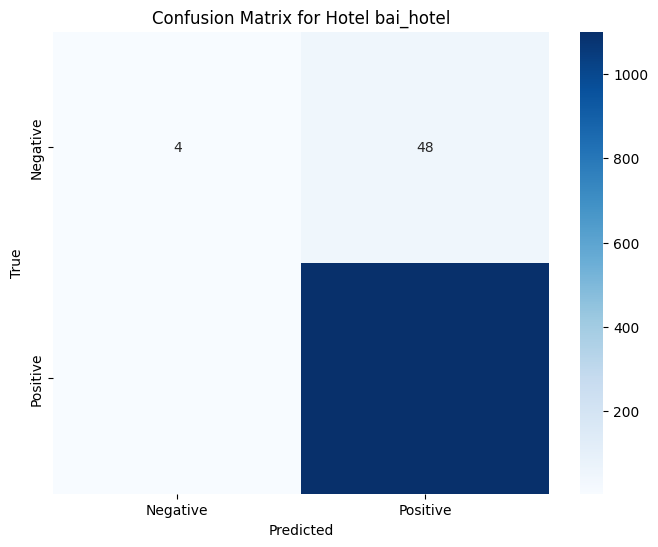

Mean Squared Error for Hotel bai_hotel: 0.025655962449863796
Predicted sentiment values for Hotel bai_hotel saved in ../predictions/1_bai_hotel



Training the CNN-biLSTM model for Hotel dusit_thani_mactan...
Epoch 1/10


c:\Users\andyb\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


36/36 ━━━━━━━━━━━━━━━━━━━━ 4s 41ms/step - accuracy: 0.4654 - loss: 0.4555 - val_accuracy: 0.4961 - val_loss: 0.4440
Epoch 2/10
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - accuracy: 0.5195 - loss: 0.3605 - val_accuracy: 0.4961 - val_loss: 0.3781
Epoch 3/10
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - accuracy: 0.4981 - loss: 0.2993 - val_accuracy: 0.4961 - val_loss: 0.4143
Epoch 4/10
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - accuracy: 0.4976 - loss: 0.2766 - val_accuracy: 0.4961 - val_loss: 0.3982
Epoch 5/10
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - accuracy: 0.5351 - loss: 0.2470 - val_accuracy: 0.4961 - val_loss: 0.4136
Epoch 6/10
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - accuracy: 0.5141 - loss: 0.2451 - val_accuracy: 0.4961 - val_loss: 0.4287
Epoch 7/10
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - accuracy: 0.5177 - loss: 0.2411 - val_accuracy: 0.4884 - val_loss: 0.4318
Epoch 8/10
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - accuracy: 0.5142 - loss: 0.2419 - val_accuracy: 0.4884 - val_loss: 0.

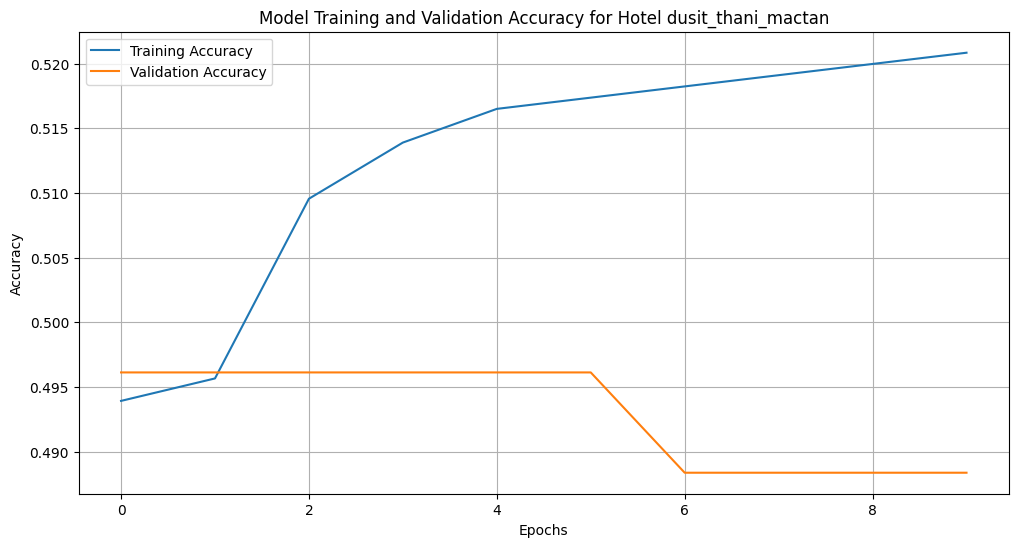

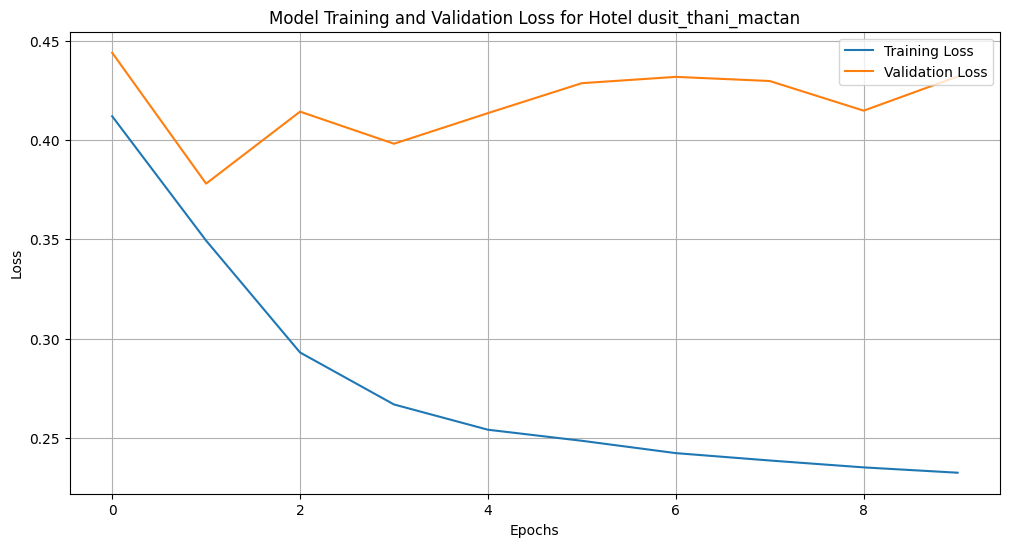

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.5253 - loss: 0.4275
Test Loss for Hotel dusit_thani_mactan: 0.4249271750450134
Test Accuracy for Hotel dusit_thani_mactan: 0.5218181610107422
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step

Classification Report for Hotel dusit_thani_mactan:
              precision    recall  f1-score   support

    Negative       0.65      0.27      0.38        83
    Positive       0.88      0.97      0.93       467

    accuracy                           0.87       550
   macro avg       0.76      0.62      0.65       550
weighted avg       0.85      0.87      0.84       550



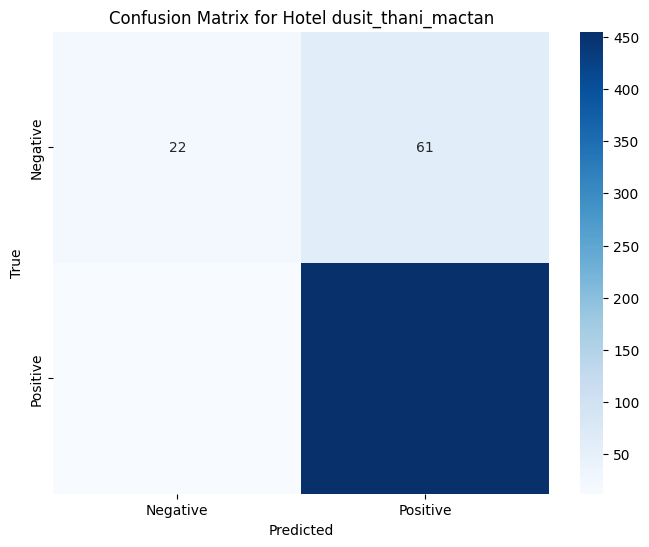

Mean Squared Error for Hotel dusit_thani_mactan: 0.04445034809286804
Predicted sentiment values for Hotel dusit_thani_mactan saved in ../predictions/2_dusit_thani_mactan



Training the CNN-biLSTM model for Hotel fairfield_by_marriott_cebu...
Epoch 1/10


c:\Users\andyb\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 423ms/step - accuracy: 0.5465 - loss: 0.5630 - val_accuracy: 0.2000 - val_loss: 0.6115
Epoch 2/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 0.6015 - loss: 0.4178 - val_accuracy: 0.2000 - val_loss: 0.7767
Epoch 3/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - accuracy: 0.5807 - loss: 0.4181 - val_accuracy: 0.2000 - val_loss: 0.7057
Epoch 4/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - accuracy: 0.6015 - loss: 0.3829 - val_accuracy: 0.2000 - val_loss: 0.6394
Epoch 5/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - accuracy: 0.5807 - loss: 0.3784 - val_accuracy: 0.2000 - val_loss: 0.6246
Epoch 6/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 0.5807 - loss: 0.3762 - val_accuracy: 0.2000 - val_loss: 0.6714
Epoch 7/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - accuracy: 0.5911 - loss: 0.3670 - val_accuracy: 0.2000 - val_loss: 0.7211
Epoch 8/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - accuracy: 0.5807 - loss: 0.3789 - val_accuracy: 0.2000 - val_loss: 0.6952
Epoch 9/10

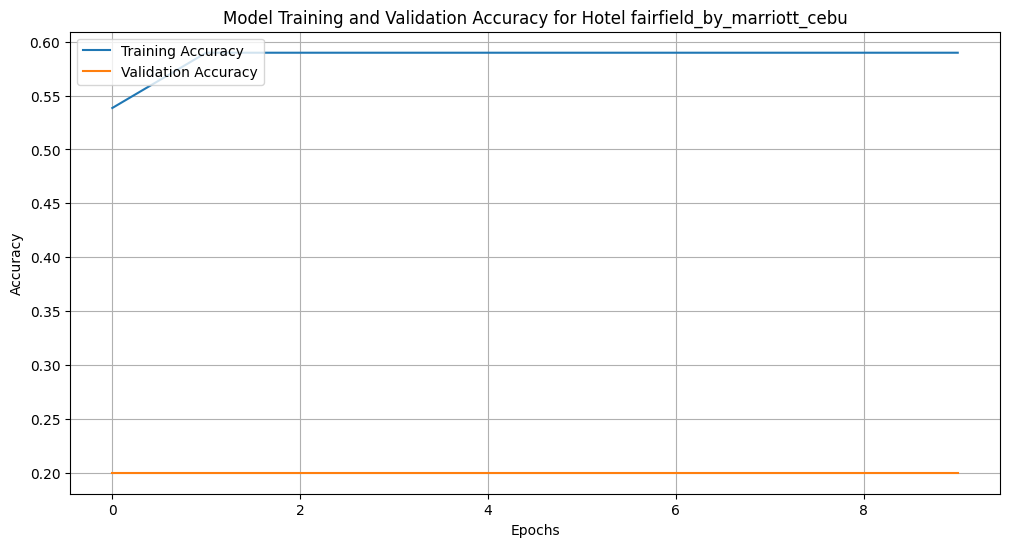

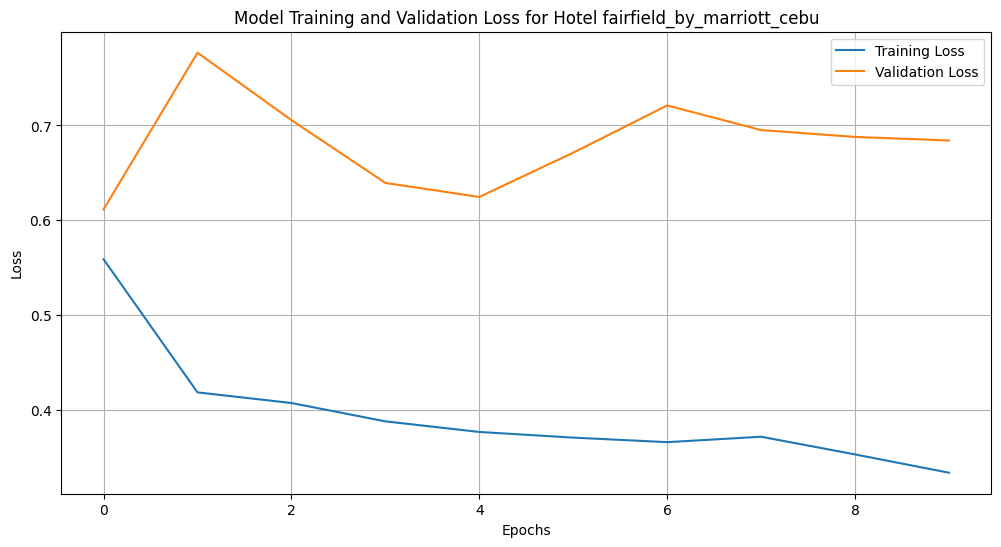

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.5000 - loss: 0.5719
Test Loss for Hotel fairfield_by_marriott_cebu: 0.571888267993927
Test Accuracy for Hotel fairfield_by_marriott_cebu: 0.5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step

Classification Report for Hotel fairfield_by_marriott_cebu:
              precision    recall  f1-score   support

    Negative       0.00      0.00      0.00         4
    Positive       0.80      1.00      0.89        16

    accuracy                           0.80        20
   macro avg       0.40      0.50      0.44        20
weighted avg       0.64      0.80      0.71        20



c:\Users\andyb\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\andyb\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\andyb\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

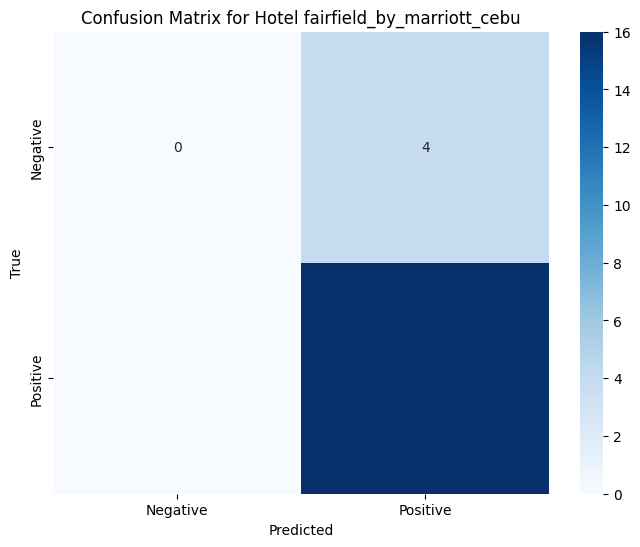

Mean Squared Error for Hotel fairfield_by_marriott_cebu: 0.08655947393637015
Predicted sentiment values for Hotel fairfield_by_marriott_cebu saved in ../predictions/3_fairfield_by_marriott_cebu



Training the CNN-biLSTM model for Hotel jpark_island_resort_and_waterpark...


c:\Users\andyb\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 3s 66ms/step - accuracy: 0.3456 - loss: 0.6808 - val_accuracy: 0.2973 - val_loss: 0.6325
Epoch 2/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.4272 - loss: 0.4704 - val_accuracy: 0.2973 - val_loss: 0.5758
Epoch 3/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.3787 - loss: 0.5010 - val_accuracy: 0.2973 - val_loss: 0.6069
Epoch 4/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.3906 - loss: 0.4812 - val_accuracy: 0.2973 - val_loss: 0.6134
Epoch 5/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.4211 - loss: 0.4371 - val_accuracy: 0.2973 - val_loss: 0.5617
Epoch 6/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.4233 - loss: 0.4086 - val_accuracy: 0.2973 - val_loss: 0.5291
Epoch 7/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.4153 - loss: 0.4095 - val_accuracy: 0.3243 - val_loss: 0.5296
Epoch 8/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.3916 - loss: 0.3979 - val_accuracy: 0.3243 - v

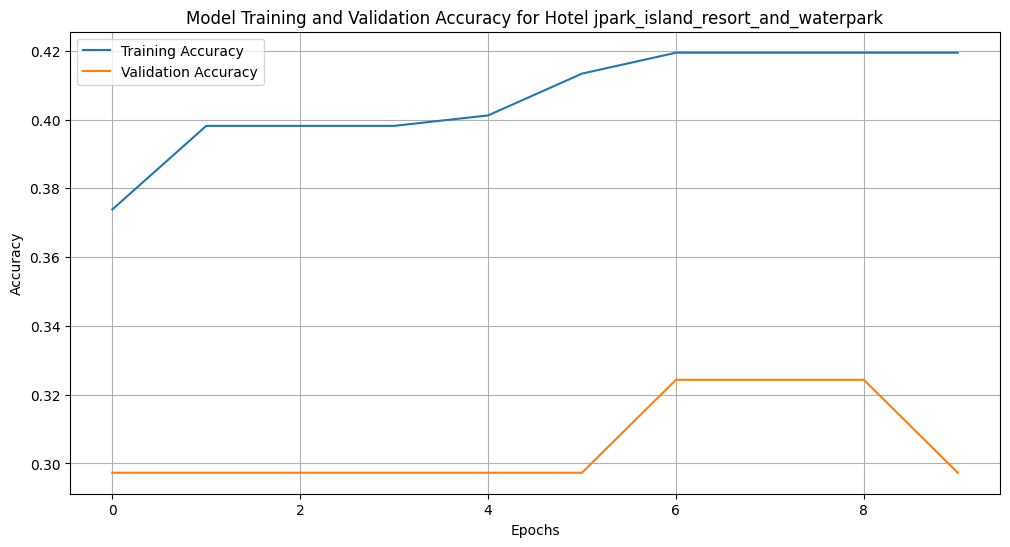

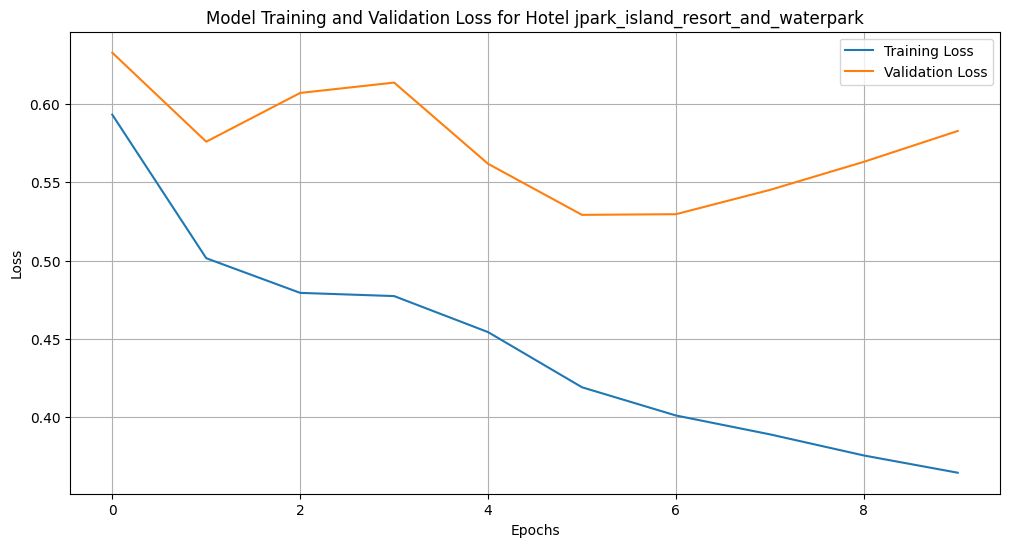

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.4222 - loss: 0.4358
Test Loss for Hotel jpark_island_resort_and_waterpark: 0.4688568115234375
Test Accuracy for Hotel jpark_island_resort_and_waterpark: 0.37974682450294495
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step

Classification Report for Hotel jpark_island_resort_and_waterpark:
              precision    recall  f1-score   support

    Negative       0.00      0.00      0.00        18
    Positive       0.88      0.98      0.93       140

    accuracy                           0.87       158
   macro avg       0.44      0.49      0.46       158
weighted avg       0.78      0.87      0.82       158



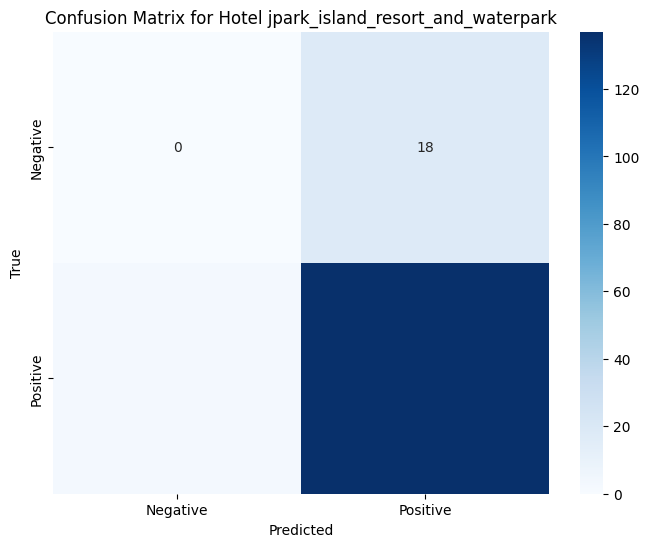

Mean Squared Error for Hotel jpark_island_resort_and_waterpark: 0.046040901635587786
Predicted sentiment values for Hotel jpark_island_resort_and_waterpark saved in ../predictions/4_jpark_island_resort_and_waterpark



Training the CNN-biLSTM model for Hotel seda_ayala_center_cebu...
Epoch 1/10


c:\Users\andyb\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


38/38 ━━━━━━━━━━━━━━━━━━━━ 4s 42ms/step - accuracy: 0.4123 - loss: 0.4878 - val_accuracy: 0.4361 - val_loss: 0.3958
Epoch 2/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - accuracy: 0.4474 - loss: 0.3943 - val_accuracy: 0.4361 - val_loss: 0.3778
Epoch 3/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - accuracy: 0.4681 - loss: 0.3405 - val_accuracy: 0.4361 - val_loss: 0.3730
Epoch 4/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - accuracy: 0.4649 - loss: 0.3177 - val_accuracy: 0.4361 - val_loss: 0.3889
Epoch 5/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - accuracy: 0.4680 - loss: 0.3021 - val_accuracy: 0.4361 - val_loss: 0.4349
Epoch 6/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - accuracy: 0.4519 - loss: 0.2947 - val_accuracy: 0.4361 - val_loss: 0.4296
Epoch 7/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - accuracy: 0.4526 - loss: 0.2856 - val_accuracy: 0.4361 - val_loss: 0.4233
Epoch 8/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - accuracy: 0.4669 - loss: 0.2837 - val_accuracy: 0.4361 - val_loss: 0.

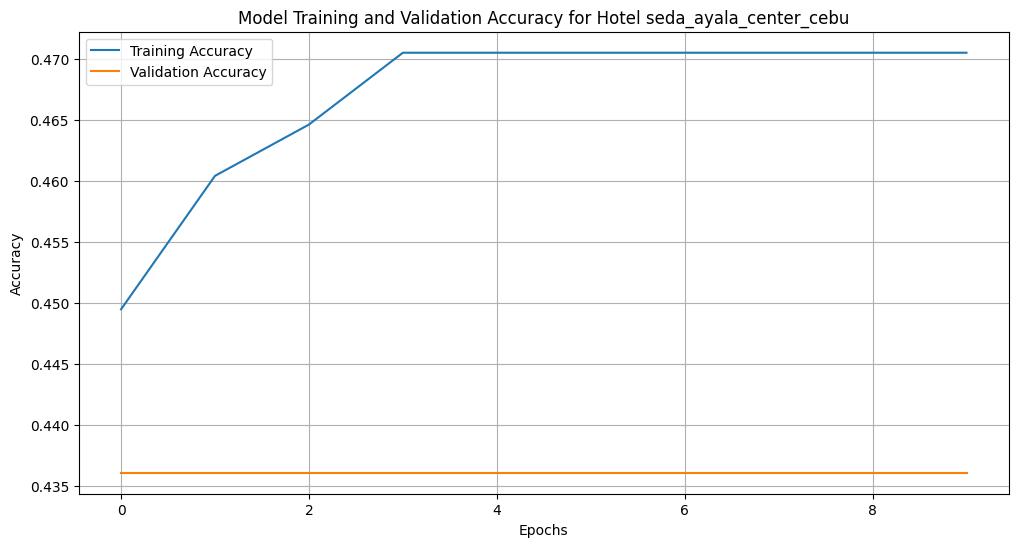

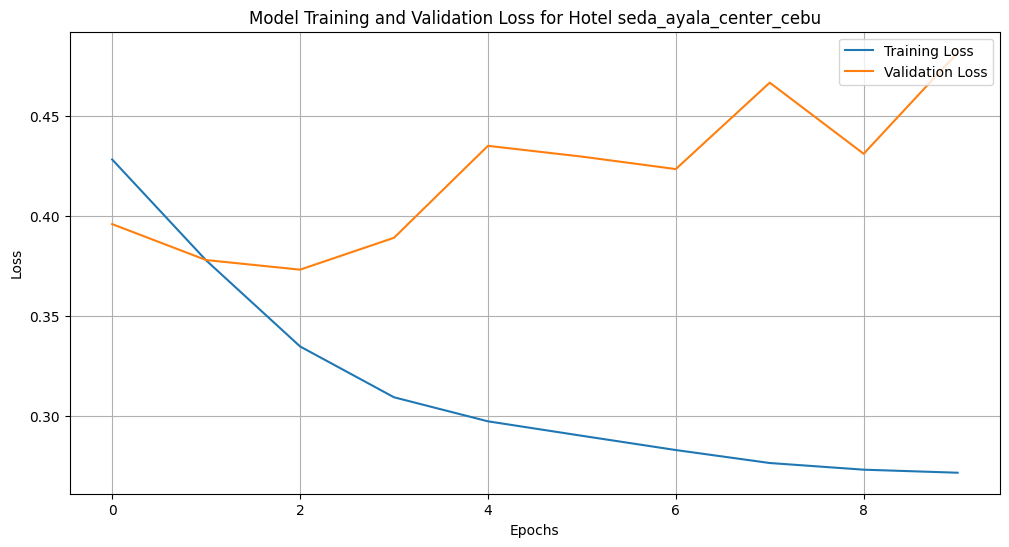

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.4372 - loss: 0.4460
Test Loss for Hotel seda_ayala_center_cebu: 0.46596354246139526
Test Accuracy for Hotel seda_ayala_center_cebu: 0.44091710448265076
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step

Classification Report for Hotel seda_ayala_center_cebu:
              precision    recall  f1-score   support

    Negative       0.44      0.09      0.15        45
    Positive       0.93      0.99      0.96       522

    accuracy                           0.92       567
   macro avg       0.69      0.54      0.55       567
weighted avg       0.89      0.92      0.89       567



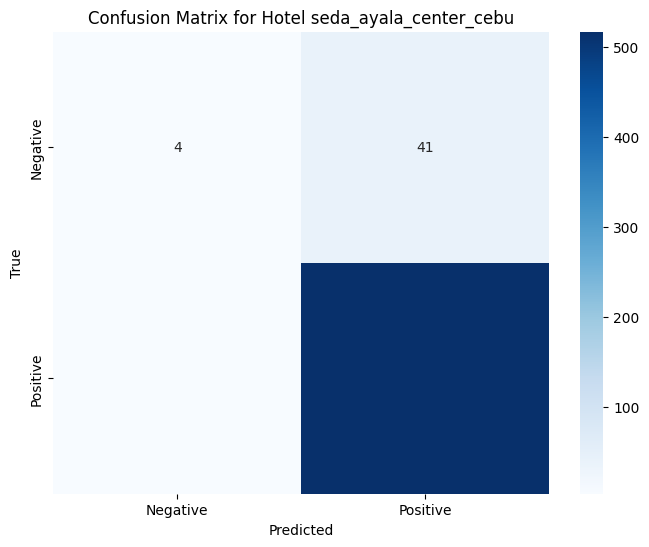

Mean Squared Error for Hotel seda_ayala_center_cebu: 0.032980482480307084
Predicted sentiment values for Hotel seda_ayala_center_cebu saved in ../predictions/5_seda_ayala_center_cebu



Training the CNN-biLSTM model for Hotel waterfront_hotel_and_casino...
Epoch 1/10


c:\Users\andyb\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


31/31 ━━━━━━━━━━━━━━━━━━━━ 4s 45ms/step - accuracy: 0.2784 - loss: 0.7343 - val_accuracy: 0.3243 - val_loss: 0.4928
Epoch 2/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - accuracy: 0.3194 - loss: 0.6232 - val_accuracy: 0.3243 - val_loss: 0.4712
Epoch 3/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - accuracy: 0.3042 - loss: 0.6118 - val_accuracy: 0.3243 - val_loss: 0.4590
Epoch 4/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - accuracy: 0.3160 - loss: 0.5556 - val_accuracy: 0.3333 - val_loss: 0.4430
Epoch 5/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - accuracy: 0.3085 - loss: 0.5357 - val_accuracy: 0.3333 - val_loss: 0.4441
Epoch 6/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - accuracy: 0.3062 - loss: 0.5206 - val_accuracy: 0.3243 - val_loss: 0.4397
Epoch 7/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - accuracy: 0.2970 - loss: 0.5214 - val_accuracy: 0.3333 - val_loss: 0.4401
Epoch 8/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - accuracy: 0.3292 - loss: 0.5033 - val_accuracy: 0.3333 - val_loss: 0.

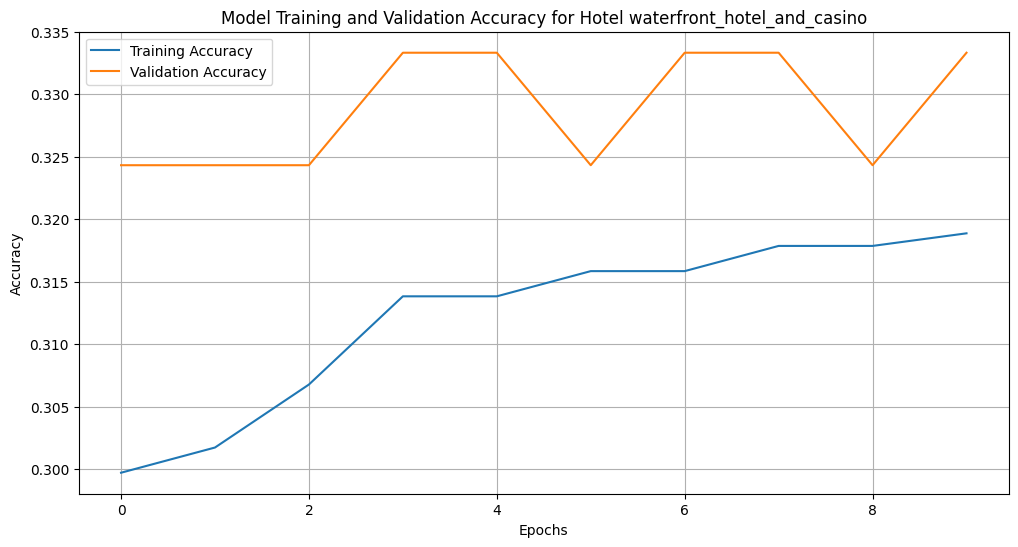

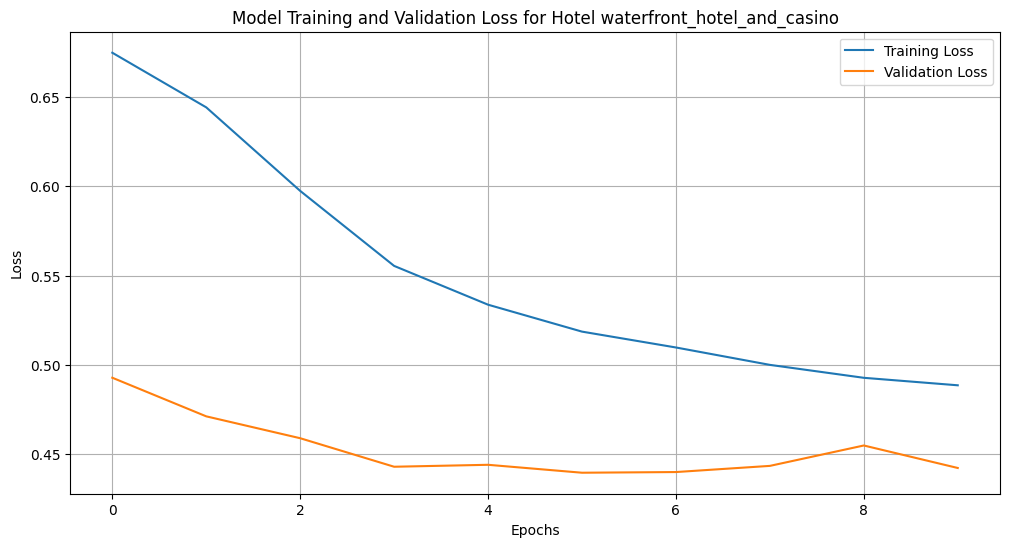

15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.2879 - loss: 0.5129
Test Loss for Hotel waterfront_hotel_and_casino: 0.5231043100357056
Test Accuracy for Hotel waterfront_hotel_and_casino: 0.3044397532939911
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step

Classification Report for Hotel waterfront_hotel_and_casino:
              precision    recall  f1-score   support

    Negative       0.62      0.29      0.40        96
    Positive       0.84      0.95      0.89       377

    accuracy                           0.82       473
   macro avg       0.73      0.62      0.65       473
weighted avg       0.80      0.82      0.79       473



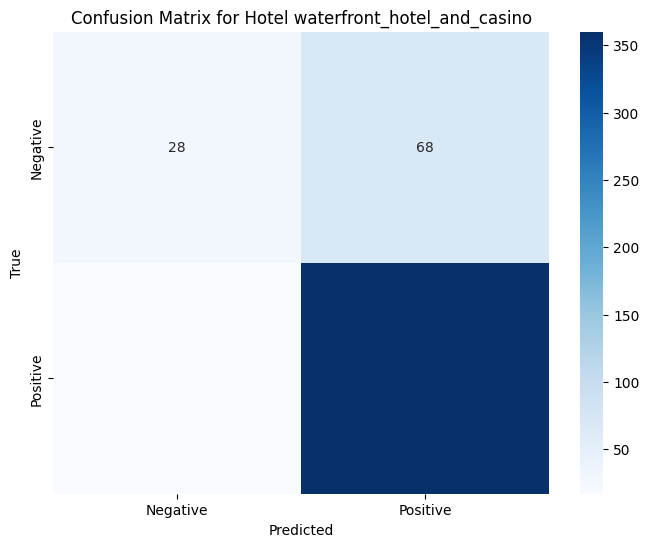

Mean Squared Error for Hotel waterfront_hotel_and_casino: 0.05256104536875049
Predicted sentiment values for Hotel waterfront_hotel_and_casino saved in ../predictions/6_waterfront_hotel_and_casino


In [40]:
import numpy as np
import pandas as pd
import os
import re
from bs4 import BeautifulSoup
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Input, Embedding, Conv1D, MaxPooling1D, LSTM, Bidirectional, Dense, Flatten, Dropout
from tensorflow.keras.models import Model
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import confusion_matrix, classification_report, mean_squared_error
import matplotlib.pyplot as plt
import seaborn as sns
from gensim.models import Word2Vec, Doc2Vec
from gensim.models.doc2vec import TaggedDocument

# Ensure nltk resources are downloaded
nltk.download('stopwords')
nltk.download('wordnet')

# Constants
VOCAB_SIZE = 10000
EMBEDDING_DIM = 100
MAX_SEQUENCE_LENGTH = 200
BATCH_SIZE = 32
EPOCHS = 10

# Initialize lemmatizer and stopwords
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

# Map hotel names to their respective folder names
hotel_folder_mapping = {
    'bai_hotel': '1_bai_hotel',
    'dusit_thani_mactan': '2_dusit_thani_mactan',
    'fairfield_by_marriott_cebu': '3_fairfield_by_marriott_cebu',
    'jpark_island_resort_and_waterpark': '4_jpark_island_resort_and_waterpark',
    'seda_ayala_center_cebu': '5_seda_ayala_center_cebu',
    'waterfront_hotel_and_casino': '6_waterfront_hotel_and_casino'
}

# Load preprocessed data for a single hotel
def load_data(hotel_name):
    try:
        folder_name = hotel_folder_mapping[hotel_name]
        data_path = f"../datasets/{folder_name}/{hotel_name}_preprocessed_reviews.npz"
        data = np.load(data_path)
        return data
    except Exception as e:
        print(f"Error loading data for {hotel_name}: {e}")
        return None

# Train and evaluate the model for a single hotel
def train_and_evaluate_model(x_train, x_test, y_train, y_test, label):
    try:
        input_text = Input(shape=(MAX_SEQUENCE_LENGTH,))
        embedding = Embedding(VOCAB_SIZE, EMBEDDING_DIM, input_length=MAX_SEQUENCE_LENGTH)(input_text)
        conv1d = Conv1D(128, 5, activation='relu')(embedding)
        maxpool = MaxPooling1D(2)(conv1d)
        bi_lstm = Bidirectional(LSTM(64, return_sequences=True))(maxpool)
        dropout = Dropout(0.5)(bi_lstm)
        flat = Flatten()(dropout)
        output = Dense(1, activation='sigmoid')(flat)
        model = Model(inputs=input_text, outputs=output)

        model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

        print(f"\n\n\nTraining the CNN-biLSTM model for {label}...")
        
        # Calculate class weights
        class_weights = {0: len(y_train) / (2 * np.bincount(y_train == 0)[0]), 
                        1: len(y_train) / (2 * np.bincount(y_train == 1)[1])}

        # Train the model with class weights
        history = model.fit(x_train, y_train, epochs=EPOCHS, batch_size=BATCH_SIZE, validation_split=0.1, class_weight=class_weights)

        plt.figure(figsize=(12, 6))
        plt.plot(history.history['accuracy'], label='Training Accuracy')
        plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
        plt.title(f'Model Training and Validation Accuracy for {label}')
        plt.xlabel('Epochs')
        plt.ylabel('Accuracy')
        plt.legend(loc='upper left')
        plt.grid(True)
        plt.show()

        plt.figure(figsize=(12, 6))
        plt.plot(history.history['loss'], label='Training Loss')
        plt.plot(history.history['val_loss'], label='Validation Loss')
        plt.title(f'Model Training and Validation Loss for {label}')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.legend(loc='upper right')
        plt.grid(True)
        plt.show()

        loss, accuracy = model.evaluate(x_test, y_test)
        print(f"Test Loss for {label}: {loss}")
        print(f"Test Accuracy for {label}: {accuracy}")

        y_pred_prob = model.predict(x_test)
        y_pred = (y_pred_prob > 0.5).astype(int)

        # Ensure y_test is binary for classification report
        y_test_binary = (y_test > 0.5).astype(int)

        print(f"\nClassification Report for {label}:")
        print(classification_report(y_test_binary, y_pred, target_names=['Negative', 'Positive']))

        conf_matrix = confusion_matrix(y_test_binary, y_pred)
        plt.figure(figsize=(8, 6))
        sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
        plt.xlabel('Predicted')
        plt.ylabel('True')
        plt.title(f'Confusion Matrix for {label}')
        plt.show()

        # Evaluate regression metrics for continuous predictions
        mse = mean_squared_error(y_test, y_pred_prob)
        print(f"Mean Squared Error for {label}: {mse}")

        # Save and print the predicted sentiment values
        output_folder = f"../predictions/{hotel_folder_mapping[label.split()[1]]}"
        os.makedirs(output_folder, exist_ok=True)
        np.savez_compressed(os.path.join(output_folder, f"{label}_predictions.npz"), y_pred_prob=y_pred_prob)
        print(f"Predicted sentiment values for {label} saved in {output_folder}")

    except Exception as e:
        print(f"Error during training and evaluation for {label}: {e}")

# List of hotels
hotels = ['bai_hotel', 'dusit_thani_mactan', 'fairfield_by_marriott_cebu', 'jpark_island_resort_and_waterpark', 'seda_ayala_center_cebu', 'waterfront_hotel_and_casino']

# Perform sentiment analysis for each hotel
for hotel in hotels:
    data = load_data(hotel)
    if data is not None:
        x_train, x_test, y_train, y_test = data['x_train'], data['x_test'], data['y_train'], data['y_test']
        train_and_evaluate_model(x_train, x_test, y_train, y_test, f'Hotel {hotel}')
    else:
        print(f"Skipping sentiment analysis for {hotel} due to data loading error.")

        
###! GENERAL ANALYSIS OF RESULTS: 
# ! 1. potential overfitting : the imbalance is likely causing the model to be biased towards predicting the positive class
# ! 2. the model correctly identifies the positive samples almost all the time but struggles significantly with the negative samples.

## Loading of predicted values

In [42]:
import numpy as np
import os

# List of hotels and their respective folders
hotel_folder_mapping = {
    'bai_hotel': '1_bai_hotel',
    'dusit_thani_mactan': '2_dusit_thani_mactan',
    'fairfield_by_marriott_cebu': '3_fairfield_by_marriott_cebu',
    'jpark_island_resort_and_waterpark': '4_jpark_island_resort_and_waterpark',
    'seda_ayala_center_cebu': '5_seda_ayala_center_cebu',
    'waterfront_hotel_and_casino': '6_waterfront_hotel_and_casino'
}

# Function to load and print predicted values
def load_and_print_predictions(hotel_name):
    folder_name = hotel_folder_mapping[hotel_name]
    prediction_path = f"../predictions/{folder_name}/Hotel {hotel_name}_predictions.npz"
    
    try:
        data = np.load(prediction_path)
        y_pred_prob = data['y_pred_prob']
        print(f"Predicted sentiment values for {hotel_name}:\n{y_pred_prob}")
    except Exception as e:
        print(f"Error loading predictions for {hotel_name}: {e}")

# List of hotels
hotels = ['bai_hotel', 'dusit_thani_mactan', 'fairfield_by_marriott_cebu', 'jpark_island_resort_and_waterpark', 'seda_ayala_center_cebu', 'waterfront_hotel_and_casino']

# Load and print predictions for each hotel
for hotel in hotels:
    load_and_print_predictions(hotel)
    
#* NOTE: these are the predicted sentiment value of EACH review


Predicted sentiment values for bai_hotel:
Review: 0, Predicted Sentiment: 0.9960834980010986
Review: 1, Predicted Sentiment: 0.8314481973648071
Review: 2, Predicted Sentiment: 0.9690610766410828
Review: 3, Predicted Sentiment: 0.9999657869338989
Review: 4, Predicted Sentiment: 0.9657732844352722
Review: 5, Predicted Sentiment: 0.9238668084144592
Review: 6, Predicted Sentiment: 0.9990246295928955
Review: 7, Predicted Sentiment: 0.9899270534515381
Review: 8, Predicted Sentiment: 0.958771824836731
Review: 9, Predicted Sentiment: 0.9958011507987976
Review: 10, Predicted Sentiment: 0.9999986886978149
Review: 11, Predicted Sentiment: 0.9954307675361633
Review: 12, Predicted Sentiment: 0.9480345845222473
Review: 13, Predicted Sentiment: 0.8196290731430054
Review: 14, Predicted Sentiment: 0.980886697769165
Review: 15, Predicted Sentiment: 0.9999857544898987
Review: 16, Predicted Sentiment: 0.9984654188156128
Review: 17, Predicted Sentiment: 0.9985944628715515
Review: 18, Predicted Sentiment: 

# Aspect-based Sentiment Analysis

In [37]:
import glob
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MultiLabelBinarizer
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Input, Embedding, Bidirectional, LSTM, Dense
from tensorflow.keras.models import Model

# Constants
VOCAB_SIZE = 10000
EMBEDDING_DIM = 100
MAX_SEQUENCE_LENGTH = 200

# Load Aspect-Based Dataset from multiple CSV files
aspect_path = r"C:\Users\andyb\Desktop\Coding Files\PointView\datasets\aspect-based\*.csv"
all_files = glob.glob(aspect_path)

# Initial empty DataFrame
aspect_data = pd.DataFrame()

# Load and unify all CSV files
for file in all_files:
    df = pd.read_csv(file)
    # Rename columns if necessary or handle missing 'Labels' column
    if 'Labels' not in df.columns:
        # Example: Assuming the column might be named 'Classification' instead
        if 'Classification' in df.columns:
            df.rename(columns={'Classification': 'Labels'}, inplace=True)
        else:
            df['Labels'] = None  # or df['Labels'] = 'default_value' if appropriate
    aspect_data = pd.concat([aspect_data, df], ignore_index=True)

# Check if 'Labels' column is properly set up
print(aspect_data.columns)

# Prepare Aspect Data
mlb = MultiLabelBinarizer()
aspect_data['Labels'] = aspect_data['Labels'].fillna('')  # Handle None or missing labels
aspect_data['Labels'] = aspect_data['Labels'].apply(lambda x: x.split(':'))
labels = mlb.fit_transform(aspect_data['Labels'])

tokenizer = Tokenizer(num_words=VOCAB_SIZE)
tokenizer.fit_on_texts(aspect_data['Opinion'])  # Assuming 'Opinion' column holds the text
sequences = tokenizer.texts_to_sequences(aspect_data['Opinion'])
aspect_padded = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH)

# Split the aspect data
x_train_aspects, x_test_aspects, y_train_aspects, y_test_aspects = train_test_split(aspect_padded, labels, test_size=0.3, random_state=42)

# Define biLSTM model for Aspect-Based Analysis
input_aspect = Input(shape=(MAX_SEQUENCE_LENGTH,))
embedding_aspect = Embedding(VOCAB_SIZE, EMBEDDING_DIM, input_length=MAX_SEQUENCE_LENGTH)(input_aspect)
bi_lstm_aspect = Bidirectional(LSTM(64, return_sequences=False))(embedding_aspect)
output_aspect = Dense(len(mlb.classes_), activation='softmax')(bi_lstm_aspect)
aspect_model = Model(inputs=input_aspect, outputs=output_aspect)

# Compile and train aspect model
print("Training the Aspect-Based Analysis model...")
aspect_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
aspect_history = aspect_model.fit(x_train_aspects, y_train_aspects, epochs=10, batch_size=32, validation_split=0.1)

# Plot training and validation accuracy
plt.figure(figsize=(10, 5))
plt.plot(aspect_history.history['accuracy'], label='Train Accuracy')
plt.plot(aspect_history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot training and validation loss
plt.figure(figsize=(10, 5))
plt.plot(aspect_history.history['loss'], label='Train Loss')
plt.plot(aspect_history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

Index(['Opinion', 'Labels'], dtype='object')
Training the Aspect-Based Analysis model...
Epoch 1/10


c:\Users\andyb\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


170/170 ━━━━━━━━━━━━━━━━━━━━ 10s 49ms/step - accuracy: 0.2530 - loss: 4.6521 - val_accuracy: 0.4785 - val_loss: 5.5421
Epoch 2/10
170/170 ━━━━━━━━━━━━━━━━━━━━ 7s 44ms/step - accuracy: 0.4162 - loss: 5.7795 - val_accuracy: 0.4785 - val_loss: 5.9801
Epoch 3/10
170/170 ━━━━━━━━━━━━━━━━━━━━ 8s 45ms/step - accuracy: 0.3150 - loss: 6.1675 - val_accuracy: 0.0993 - val_loss: 6.3393
Epoch 4/10
170/170 ━━━━━━━━━━━━━━━━━━━━ 8s 46ms/step - accuracy: 0.2994 - loss: 6.4041 - val_accuracy: 0.0993 - val_loss: 6.7507
Epoch 5/10
170/170 ━━━━━━━━━━━━━━━━━━━━ 9s 50ms/step - accuracy: 0.2733 - loss: 6.6940 - val_accuracy: 0.4785 - val_loss: 7.0802
Epoch 6/10
170/170 ━━━━━━━━━━━━━━━━━━━━ 8s 48ms/step - accuracy: 0.3462 - loss: 7.3290 - val_accuracy: 0.4785 - val_loss: 7.5129
Epoch 7/10
 37/170 ━━━━━━━━━━━━━━━━━━━━ 6s 49ms/step - accuracy: 0.4698 - loss: 7.6051

KeyboardInterrupt: 

## KDE for each hotel

15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step


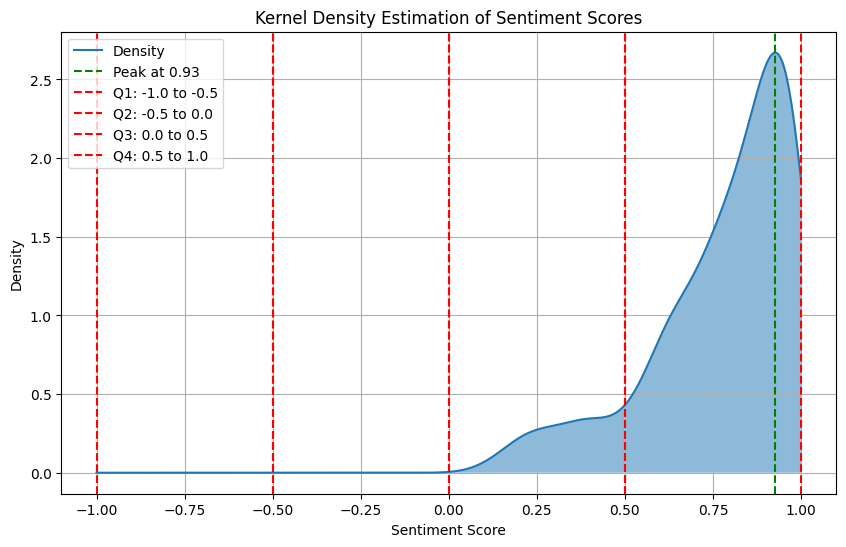

Peak value: 0.93
Quartiles: [(-1.0, -0.5), (-0.5, 0.0), (0.0, 0.5), (0.5, 1.0)]


In [ ]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde
from tensorflow.keras.models import Model

y_pred = model.predict(x_test).flatten()  

# Define a function to plot KDE, identify peak, and fixed quartiles
def plot_kde_and_statistics(predictions, title="Sentiment Analysis Distribution"):
    plt.figure(figsize=(10, 6))
    kde = gaussian_kde(predictions)
    scores = np.linspace(-1, 1, 1000)  # fixed range for sentiment scores
    density = kde(scores)
    plt.plot(scores, density, label='Density')
    plt.fill_between(scores, density, alpha=0.5)

    # Identify peak
    peak = scores[np.argmax(density)]
    plt.axvline(x=peak, color='green', linestyle='--', label=f'Peak at {peak:.2f}')

    # Define fixed quartile ranges
    quartile_ranges = {
        'Q1': (-1.0, -0.5),
        'Q2': (-0.5, 0.0),
        'Q3': (0.0, 0.5),
        'Q4': (0.5, 1.0)
    }

    # Plot quartile ranges
    for label, (start, end) in quartile_ranges.items():
        plt.axvline(x=start, linestyle='--', color='red', label=f'{label}: {start} to {end}')
        plt.axvline(x=end, linestyle='--', color='red')

    plt.title(title)
    plt.xlabel('Sentiment Score')
    plt.ylabel('Density')
    plt.legend()
    plt.grid(True)
    plt.show()

    print(f"Peak value: {peak:.2f}")
    print(f"Quartiles: {list(quartile_ranges.values())}")

# Call the function to plot KDE and statistics
plot_kde_and_statistics(y_pred, title="Kernel Density Estimation of Sentiment Scores")

In [ ]:
import pandas as pd
import os

# Assuming 'aspect_predictions' is your predictions from the model
# and 'mlb.classes_' contains the class labels

# Predicting aspects using the trained model
aspect_predictions = aspect_model.predict(x_test)

# Convert aspect predictions to percentage likelihoods
aspect_likelihoods = np.mean(aspect_predictions, axis=0) * 100  # Average predictions and convert to percentage

# Map percentage likelihoods to corresponding labels
aspect_percentages = {label: percent for label, percent in zip(mlb.classes_, aspect_likelihoods)}
print("Aspect percentages:", aspect_percentages)

# Create a DataFrame to hold the labels and their corresponding percentage likelihoods
aspect_percentages_df = pd.DataFrame({
    'Aspect': mlb.classes_,
    'Percentage Likelihood': aspect_likelihoods
})

# Sort the DataFrame by likelihood in descending order for better readability
aspect_percentages_df = aspect_percentages_df.sort_values(by='Percentage Likelihood', ascending=False)

# # Specify the path where you want to save the CSV
# output_dir = '/datasets/aspect-based-results/'
# output_filename = 'waterfront_aspect_percentages.csv'

# # Check if the directory exists, if not, create it
# if not os.path.exists(output_dir):
#     os.makedirs(output_dir)

# # Build the complete file path
# file_path = os.path.join(output_dir, output_filename)

# # Save the DataFrame to a CSV file
# aspect_percentages_df.to_csv(file_path, index=False)

# Print the DataFrame
aspect_percentages_df


15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step
Aspect percentages: {'': 0.0, 'Cleanliness': 1.8867376e-11, 'Comfort & Facilities': 29.187944, 'Food': 35.120018, 'Internet': 0.0, 'Location': 5.216267, 'Staff': 30.139652, 'Value for money': 0.33602843}


,Aspect,Percentage Likelihood
3,Food,3.512002e+01
6,Staff,3.013965e+01
2,Comfort & Facilities,2.918794e+01
5,Location,5.216267e+00
7,Value for money,3.360284e-01
1,Cleanliness,1.886738e-11
0,,0.000000e+00
4,Internet,0.000000e+00
